In [ ]:
#############################################################################
############################# Assignment 2 ##################################
######################### Author: Shawn Liu #################################
#############################################################################

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


In [ ]:
#mount to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/458_AI/Assignment2/'

In [ ]:
# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#**Loading data & EDA**

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [ ]:
#review labels and distribution of sample
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


<BarContainer object of 10 artists>

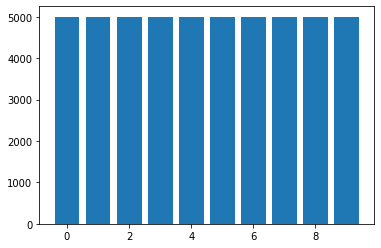

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)

frequency_trn = np.array((unique, counts))
plt.bar(frequency_trn[0], frequency_trn[1])

In [ ]:
#plot some examples

def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

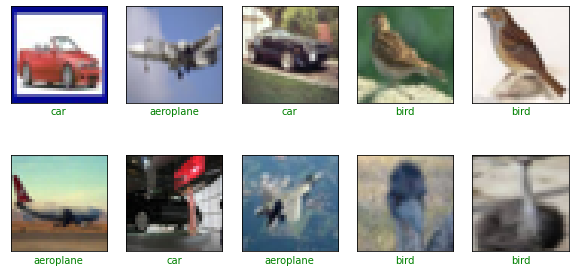

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

#**Preprocessing Data For Model Development**

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [ ]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [ ]:
#check dataset size and dimension, 10% of training data is hold out for validation purpose
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
#scale normalize the data
#The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
# 1. Each element in each example is a pixel value
# 2. Pixel values range from 0 to 255
# 3. 0 = black
# 4. 255 = white

In [ ]:
x_train_norm = x_train_split / 255 
x_valid_norm = x_valid_split / 255
x_test_norm = x_test / 255

In [ ]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [ ]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [ ]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val, x_test, y_test):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val

  pred_test = class_output(model.predict(x_test))
  ac_test = accuracy_score(y_test, pred_test)
  result_dic['accuracy_test'] = ac_test
  f1_test = f1_score(y_test, pred_test, average = 'macro')
  result_dic['f1_test'] = f1_test
  recall_test = recall_score(y_test, pred_test, average = 'macro')
  result_dic['recall_test'] = recall_test
  precision_test = precision_score(y_test, pred_test, average = 'macro')
  result_dic['precision_test'] = precision_test
  
  return result_dic

#**Experiment 6 - GridSearch on other hyperparameters for improvement upon best CNN model from experiment 5**

since CNN (model 8) outperforms others in training and test, I will use model 8 as the base and fine tune the hyperparameters to find the derived model that can improve the performance even further

The major problem with model 8 seems to be the overfitting proved by discrepency between trainging and test/validation set. I propose to add data augmentation layers as well tuning regularizers to improve it



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.callbacks import EarlyStopping

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# data augmentation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def create_cnn_model(pool_type='max', conv_activation='sigmoid', dropout_rate=0.3, kernel_size = (3,3), optimizer = 'adam'):
    # create model
    model = Sequential()
    
    # first layer: convolution
    model.add(Conv2D(filters=128, kernel_size=kernel_size, strides=(1, 1), activation='relu', input_shape=(32, 32, 3))) 
        
    # second series of layers: convolution, pooling, and dropout
    model.add(Conv2D(filters=256, kernel_size=kernel_size, strides=(1, 1), activation=conv_activation))  
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))

     # third series of layers: convolution, pooling, and dropout    
    model.add(Conv2D(filters=512, kernel_size=kernel_size, strides=(1, 1), activation=conv_activation))   
    if pool_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    if pool_type == 'average':
        model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate))     
      
    # fourth series
    model.add(Flatten())
    model.add(layers.BatchNormalization())         
    model.add(Dense(units = 384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001))) 
    # add a dropout layer if rate is not null    
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
        
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
        )    
    return model 

In [ ]:
# create model
model = KerasClassifier(build_fn=create_cnn_model, verbose=1)
# define parameters and values for grid search 
param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['sigmoid', 'tanh', 'relu'],    
    'kernel_size': [(3,3), (5,5)],
    'epochs': [10], 
    'optimizer': ['rmsprop', 'adam']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train_norm, y_train_split)

# summarize results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Epoch 1/10
938/938 [==============================] - 20s 12ms/step - loss: 3.1360 - accuracy: 0.2996
Epoch 2/10
938/938 [==============================] - 12s 12ms/step - loss: 2.3646 - accuracy: 0.4351
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 2.0967 - accuracy: 0.5037
Epoch 4/10
938/938 [==============================] - 11s 12ms/step - loss: 1.9243 - accuracy: 0.5484
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 1.7599 - accuracy: 0.5779
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss: 1.6601 - accuracy: 0.6007
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 1.6060 - accuracy: 0.6097
Epoch 8/10
938/938 [==============================] - 12s 13ms/step - loss: 1.5691 - accuracy: 0.6176
Epoch 9/10
938/938 [==============================] - 11s 12ms/step - loss: 1.5353 - accuracy: 0.6271
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 1.8068 

KeyboardInterrupt: ignored

In [ ]:
print(grid_result.best_params_)

In [ ]:
import joblib
joblib.dump(grid, 'best_cnn.pkl')

In [ ]:
joblib.load("best_cnn.pkl")

In [29]:
start_time = time.time()

model_no_da = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'], 
                             dropout_rate = 0.3, 
                             kernel_size = grid_result.best_params_['kernel_size'],
                             optimizer = grid_result.best_params_['optimizer']
                             )

history_no_da = model_no_da.fit(x_train_norm, 
                               y_train_split, 
                               batch_size=512,
                               epochs = 100, 
                               validation_data = (x_valid_norm, y_valid_split),
                              verbose = 1, 
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                                             tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

end_time = time.time()

NameError: ignored

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_no_da.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model_no_da.predict(x_test_norm)
print('shape of preds: ', preds.shape)

In [ ]:
model_noda_score = score_track(model_no_da, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_noda_score['train_time'] = train_time

In [ ]:
history_dict = history_no_da.history
history_dict.keys()

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

In [ ]:
losses = history_no_da.history['loss']
accs = history_no_da.history['accuracy']
val_losses = history_no_da.history['val_loss']
val_accs = history_no_da.history['val_accuracy']
epochs = len(losses)

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_no_da= model_no_da.predict(x_test_norm)
pred_no_da=np.argmax(pred_no_da, axis=1)

In [ ]:
print_validation_report(y_test, pred_no_da)

In [ ]:
plot_confusion_matrix(y_test,pred_no_da)

**Data Augmentation is introduced to see whether the overfitting could be reduced as well as achieving some accuracy improvement gain

In [ ]:
# optimize parameters of the fit method 
model_da = create_cnn_model(pool_type = grid_result.best_params_['pool_type'],
                             conv_activation = grid_result.best_params_['conv_activation'], 
                             dropout_rate = 0.3, 
                             kernel_size = grid_result.best_params_['kernel_size'],
                             optimizer = grid_result.best_params_['optimizer']
                             )

##data augmentation transform
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='constant', cval = 0.0)

datagen.fit(x_train_norm)

history_da = model_da.fit_generator(datagen.flow(x_train_norm, y_train_split, batch_size=512),
                                  epochs = 100, 
                                  validation_data = (x_valid_norm, y_valid_split),
                                  verbose = 1, 
                                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10), ##give it a little bit more patience
                                             tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )



**adding more CNN layers into CNN network**

In [31]:
model_deep = models.Sequential()
#remove data augmentation layer
#model_deep.add(layers.RandomFlip("horizontal_and_vertical"))
#model_1deep.add(layers.RandomRotation(0.2))
model_deep.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_deep.add(layers.AveragePooling2D((2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_deep.add(layers.AveragePooling2D(pool_size=(2, 2),strides=2))
model_deep.add(layers.Dropout(0.2))
model_deep.add(layers.Flatten())
model_deep.add(layers.BatchNormalization())
model_deep.add(layers.Dense(units=384, activation=tf.nn.relu))
model_deep.add(layers.Dense(units=10, activation=tf.nn.softmax))

ValueError: ignored

#**Result1**
Create a table with the accuracy and loss for train/test/validation & process time for ALL the models.

In [ ]:
score = [model_1_score, model_2_score, model_3_score, model_4_score, model_5_score, model_6_score, model_7_score, model_8_score, model_9_score, model_10_score]

In [ ]:
Perf_table = pd.DataFrame(score, index =['model1', 'model2', 'model3','model4','model5','model6','model7','model8','model9','model10'])

description = ['DNN-2 layer-no regularization',
               'DNN-3 layer-no regularization',
               'CNN-2 layer-no regularization',
               'CNN-3 layer-no regularization',
               'DNN-2 layer-with L2 regularization / Dropout / BatchNormalization',
               'DNN-3 layer-with L2 regularization / Dropout / BatchNormalization',
               'CNN-2 layer-with L2 regularization / Dropout / BatchNormalization',
               'CNN-3 layer-with L2 regularization / Dropout / BatchNormalization',
               'CNN-2 layer-Data Augmentation (rotate/flip)',
               'CNN-3 layer-Data Augmentation (rotate/flip)',
]

Perf_table.insert(0, 'Description', description)

Perf_table

,Description,accuracy_train,accuracy_valid,accuracy_test,f1_test,recall_test,precision_test,train_time
model1,DNN-2 layer-no regularization,0.513000,0.4586,0.4744,0.461351,0.4744,0.486725,20.908893
model2,DNN-3 layer-no regularization,0.488000,0.4500,0.4622,0.449745,0.4622,0.476422,8.297839
model3,CNN-2 layer-no regularization,0.917267,0.7126,0.7104,0.708750,0.7104,0.718264,61.643661
model4,CNN-3 layer-no regularization,0.853200,0.7306,0.7289,0.726467,0.7289,0.732115,41.099482
model5,DNN-2 layer-with L2 regularization / Dropout /...,0.442578,0.4164,0.4345,0.430742,0.4345,0.444887,11.816478
model6,DNN-3 layer-with L2 regularization / Dropout /...,0.427933,0.3990,0.4163,0.398141,0.4163,0.432377,9.910189
model7,CNN-2 layer-with L2 regularization / Dropout /...,0.965511,0.7546,0.7529,0.751482,0.7529,0.759941,72.869413
model8,CNN-3 layer-with L2 regularization / Dropout /...,0.958822,0.8008,0.7988,0.796384,0.7988,0.800900,86.047304
model9,CNN-2 layer-Data Augmentation (rotate/flip),0.583667,0.5616,0.5680,0.548915,0.5680,0.569648,42.727110
model10,CNN-3 layer-Data Augmentation (rotate/flip),0.578022,0.5576,0.5634,0.549912,0.5634,0.589437,41.628106


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_2.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_2.ipynb to html
[NbConvertApp] Writing 608445 bytes to /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_2.html
